In [1]:
# add parent directory to path
import sys
sys.path.append('..')
import dynasim

from mdof_osa_pinn import osa_pinn_mdof, normalise
# from mdof_oscillators import mdof_solution, add_noise, generate_excitation

import string

import numpy as np
import torch

import time as clock_time

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

%load_ext autoreload
%autoreload 2

def select_alt(data, inds):
    mask = torch.ones_like(data, dtype=torch.bool)
    mask[inds]=False
    return data[mask]

In [2]:
# create system for RK4 time calculations

n_dof = 3

# set physical parameters
k_ = np.array([15.0, 30.0, 20.0])
c_ = np.array([0.25, 0.3, 0.2])
m_ = np.array([10.0, 10.0, 10.0])
kn_ = np.array([100.0, 0.0, 0.0])

# create nonlinearity
cubic_nonlin = dynasim.nonlinearities.exponent_stiffness(kn_, exponent=3, dofs=n_dof)

# instantiate system
system = dynasim.systems.cantilever(m_, c_, k_, dofs=n_dof, nonlinearity=cubic_nonlin)

# generate excitations
system.excitations = [
    None,
    dynasim.actuators.sinusoid(2.1, f0=1.0, phi=0.0),
    dynasim.actuators.sinusoid(0.8, f0=1.0, phi=1.0)]

time = np.linspace(0, 1, 16)

# simulate to get simulator ready
data = system.simulate(time, z0=None)

/Users/marcus/My Drive/Work/eth/experiments/dynamic-pinns/mdof_osa/../dynasim/base.py:81: UserWarning: No initial conditions provided, proceeding with zero initial state
  warnings.warn('No initial conditions provided, proceeding with zero initial state', UserWarning)


In [3]:
result_data = torch.load('results/osa_forced_mdof.pth')
osa_config = result_data['osa_config']
ground_truth = result_data['ground_truth']
alphas = result_data['alphas']
prediction = result_data['prediction']
data = result_data['data']

nt = 512
time = np.linspace(0,60,nt)

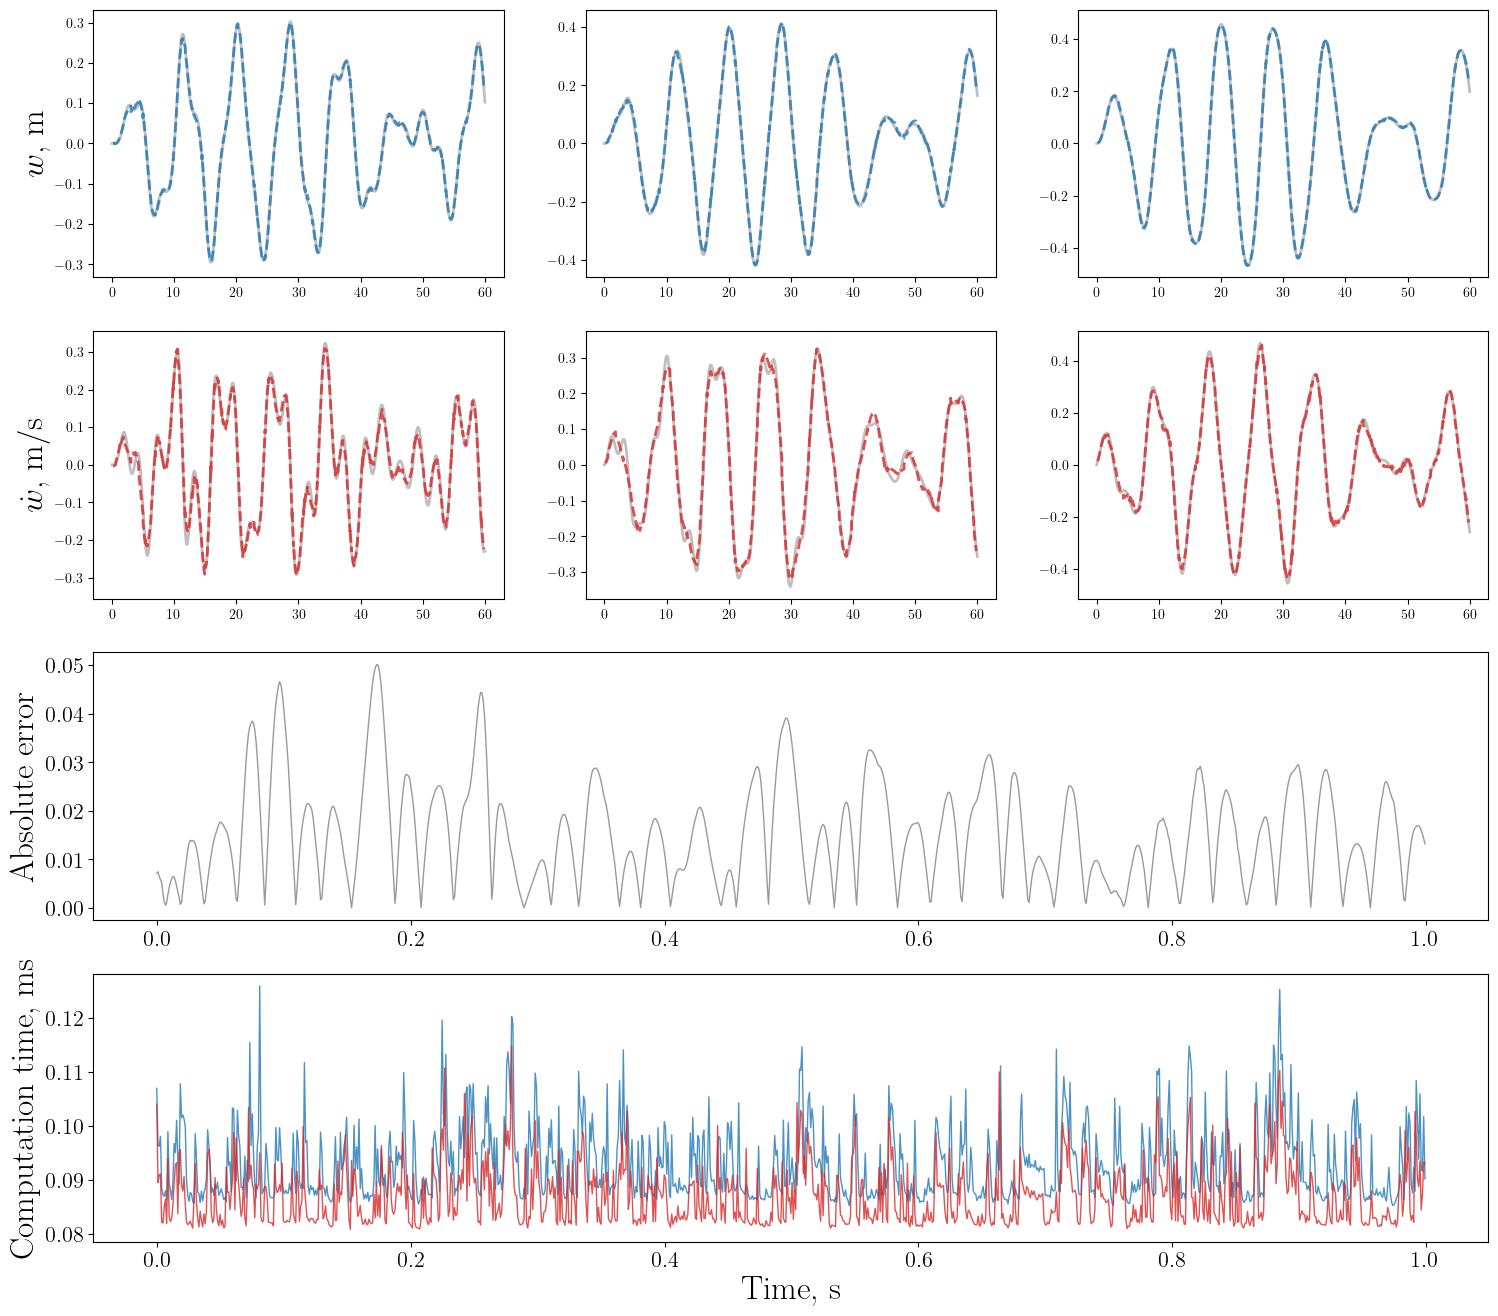

In [9]:
t_hat_gt = result_data['ground_truth']['t_hat'].squeeze()
x_hat_gt = result_data['ground_truth']['x_hat'].squeeze()
v_hat_gt = result_data['ground_truth']['v_hat'].squeeze()
F_hat_gt = result_data['ground_truth']['F_hat'].squeeze()

alpha_t = osa_config['alphas']['t']
alpha_x = osa_config['alphas']['x']
alpha_v = osa_config['alphas']['v']
alpha_F = osa_config['alphas']['F']

t_test = t_hat_gt[:-1]
x0_test = x_hat_gt[:-1]
v0_test = v_hat_gt[:-1]
f0_test = F_hat_gt[:-1]
z_obs = torch.cat((x_hat_gt[1:], v_hat_gt[1:]), dim=1)
T_hat = t_hat_gt[1].item() - t_hat_gt[0].item()
T = T_hat * alpha_t

osa_model = osa_pinn_mdof(osa_config)
osa_model.load_state_dict(result_data['model'])

n_test = t_test.shape[0]
err_pinn = [0] * n_test
cp_times = [0] * n_test
in_time = [False] * n_test
z_pred_pinn = np.zeros((n_test, 2*n_dof))
z_pred_rk4 = np.zeros((n_test, 2*n_dof))

# get many clock times for averaging
n_mean = 25
cp_times_pinn = np.zeros((n_test, n_mean))
cp_times_rk4 = np.zeros((n_test, n_mean))

dt = (t_test[1]-t_test[0]).item()

for j in range(n_mean):

    for i in range(n_test):

        z_true = z_obs[i,:] * alpha_x

        st_pinn = clock_time.process_time()
        pred_val = osa_model.predict_new(x0_test[i], v0_test[i], T_hat, f0_test[i])
        et_pinn = clock_time.process_time()
        z_pred_pinn[i, :] = pred_val.detach() * alpha_x
        err_pinn[i] = np.sum(z_pred_pinn[i,:] - (z_obs[i,:] * alpha_x).numpy())
        cp_times_pinn[i,j] = et_pinn - st_pinn

        st_rk4 = clock_time.process_time()
        z0 = torch.cat((x0_test[i,:], v0_test[i,:])).numpy()
        z_pred_rk4[i, :] = system.simulator.sim_one(dt, z0, t_test[i].item())
        # clock_time.sleep(0.002)
        et_rk4 = clock_time.process_time()
        cp_times_rk4[i,j] = et_rk4 - st_rk4

        # in_time[i] = cp_times[i,j] < T

cp_times_pinn = np.mean(cp_times_pinn, axis=1)
cp_times_rk4 = np.mean(cp_times_rk4, axis=1)
# in_time = cp_times < T.item()

mosaic_key = "ABC;DEF;GGG;HHH"
fig, axs = fig, axs = plt.subplot_mosaic(
    mosaic_key,
    figsize=(18,16),
    facecolor='w'
)

if n_dof > 4:
    sub_rows = n_dof // 4 + int((n_dof%4)!=0)
    sub_cols = 4
else:
    sub_rows = 1
    sub_cols = n_dof

alphabet = list(string.ascii_uppercase)

def plot_result(axs_m, ground_truth, data, prediction, alphas, R_=None, axs2=None):
    for ax in axs_m:
        axs_m[ax].cla()
        if axs2 is not None:
            axs2[ax].cla()
    axs_top_list = []
    for j in range(sub_rows):
        axs_top_list.append([axs_m[alphabet[2*sub_cols*j+i]] for i in range(sub_cols)])
        axs_top_list.append([axs_m[alphabet[2*sub_cols*j+sub_cols+i]] for i in range(sub_cols)])
    axs_top = np.array(axs_top_list)

    if axs2 is not None:
        axs2_top_list = []
        for j in range(sub_rows):
            axs2_top_list.append([axs2[alphabet[2*sub_cols*j+i]] for i in range(sub_cols)])
            axs2_top_list.append([axs2[alphabet[2*sub_cols*j+sub_cols+i]] for i in range(sub_cols)])
        axs2_top = np.array(axs2_top_list)

    plot_keys = ["x_hat", "v_hat"]
    plot_cols = ["tab:blue", "tab:red"]
    p_count = 0
    for j in range(sub_rows):
        for i in range(sub_cols):
            for n in range(2):
                # axs_top[j*2+n,i].plot(data["t_hat"].detach()*alphas["t"], data[plot_keys[n]][:,p_count].detach()*alphas["x"], color="tab:olive", linewidth=3, alpha=0.8, label='Training data')
                axs_top[j*2+n,i].plot(ground_truth["t_hat"]*alphas["t"], ground_truth[plot_keys[n]][:,p_count]*alphas["x"], color="grey", linewidth=2, alpha=0.5, label="Exact solution")
                axs_top[j*2+n,i].plot(prediction["t_hat"].detach()*alphas["t"], prediction[plot_keys[n]][:,p_count]*alphas["x"], color=plot_cols[n], linewidth=2, alpha=0.8, linestyle='--', label="Neural network prediction")
                # axs_top[j*2+n,i].scatter(data["t_hat"].detach()*alphas["t"], data[plot_keys[n]][:,p_count].detach()*alphas["x"], s=30, color="tab:orange", alpha=0.4, label='Training data')
                # l = axs[i,j].legend(frameon=False, fontsize="large")
                xL = torch.amax(ground_truth["t_hat"])*alphas["t"]
                yL = torch.amax(torch.abs(ground_truth[plot_keys[n]][:,p_count]))*alphas["x"]
                axs_top[j*2+n,i].set_xlim(-0.05*xL, 1.05*xL)
                axs_top[j*2+n,i].set_ylim(-1.1*yL, 1.1*yL)
            if R_ is not None:
                axs2_top[j*2,i].plot(prediction["t_hat"].detach()*alphas["t"], R_[:,p_count].detach(), color="tab:green", linewidth=1, alpha=0.8, label="SS-Phys residual")

            p_count += 1
            if p_count == n_dof:
                break

plot_result(axs, ground_truth, data, prediction, alphas)

axs["A"].set_ylabel("$w$, m", fontsize=24)
axs["D"].set_ylabel("$\dot{w}$, m/s", fontsize=24)

axs["G"].plot(t_test, np.abs(err_pinn), color="grey", linewidth=1, alpha=0.8)
axs["G"].set_ylabel("Absolute error", fontsize=24)
axs["G"].tick_params(axis='both', which='major', labelsize=16)

axs["H"].plot(t_test, np.array(cp_times_pinn)*1e3, color="tab:blue", linewidth=1, alpha=0.8)
axs["H"].plot(t_test, np.array(cp_times_rk4)*1e3, color="tab:red", linewidth=1, alpha=0.8)
axs["H"].set_xlabel("Time, s", fontsize=24)
axs["H"].set_ylabel("Computation time, ms", fontsize=24)
axs["H"].tick_params(axis='both', which='major', labelsize=16)

Number of estimates in time: 0
Maximum compute time: 0.0000e+00s
RMSE: 1.8334e-02


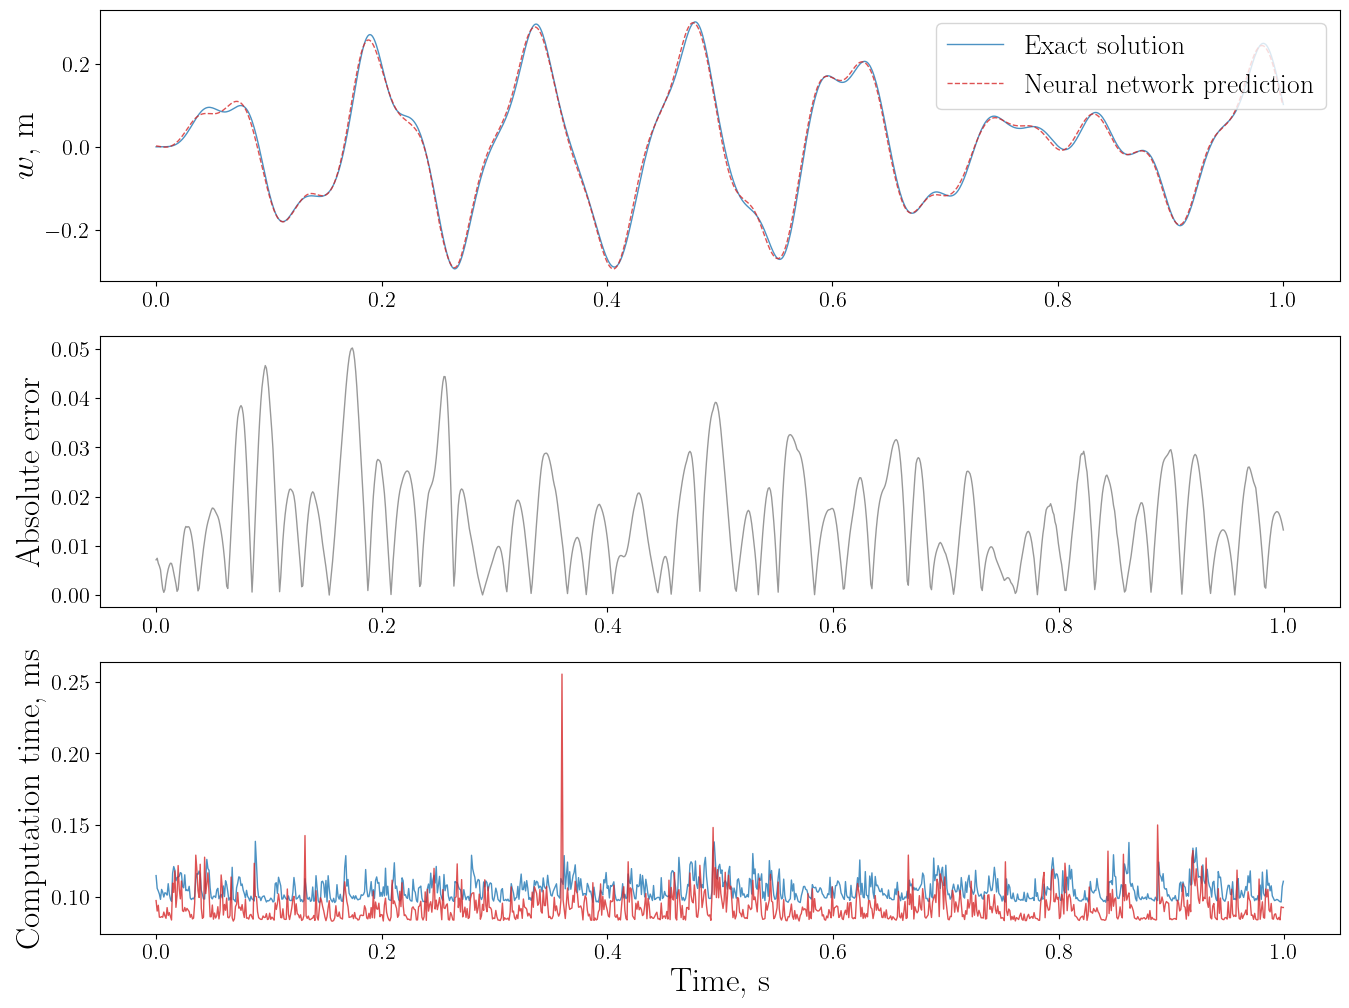

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(16,12))
axs[0].plot(t_hat_gt, x_hat_gt[:,0]*alpha_x, color="tab:blue", linewidth=1, alpha=0.8, label="Exact solution")
axs[0].plot(t_test, z_pred_pinn[:,0], color="tab:red", linestyle="--", linewidth=1, alpha=0.8, label="Neural network prediction")
# axs[0].set_xlabel("Time, s", fontsize=24)
axs[0].set_ylabel("$w$, m", fontsize=24)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].legend(fontsize=20)

axs[1].plot(t_test, np.abs(err_pinn), color="grey", linewidth=1, alpha=0.8)
# axs[1].set_xlabel("Time, s", fontsize=24)
axs[1].set_ylabel("Absolute error", fontsize=24)
axs[1].tick_params(axis='both', which='major', labelsize=16)

axs[2].plot(t_test, np.array(cp_times_pinn)*1e3, color="tab:blue", linewidth=1, alpha=0.8)
axs[2].plot(t_test, np.array(cp_times_rk4)*1e3, color="tab:red", linewidth=1, alpha=0.8)
axs[2].set_xlabel("Time, s", fontsize=24)
axs[2].set_ylabel("Computation time, ms", fontsize=24)
axs[2].tick_params(axis='both', which='major', labelsize=16)

# axs[0].plot(time[:-1], err)
# axs[0].set_yscale('log')
# axs[0].set_ylim((0,10))
# axs[0].plot(time[:-1],x_pred)
# axs[1].plot(cp_times)
# axs[0].plot(t_data,x_data)
# axs[1].plot(t_test,x_test)

RMSE = np.sqrt(np.mean(np.array(err_pinn)**2))
num_in_time = np.sum(in_time)
max_comp_time = np.max(cp_times)

print("Number of estimates in time: %d\nMaximum compute time: %.4es\nRMSE: %.4e" % (num_in_time, max_comp_time, RMSE))